In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.0 MB/s 


In [ ]:
import numpy as np
import pickle    
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import keras_tuner as kt
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Dense, SimpleRNN, Activation
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "drive/MyDrive/assignment4_pattern/RML2016.10b.dat"

In [ ]:

with open(path, 'rb') as f:
    x = pickle.load(f, encoding='latin1') 

In [ ]:
print(len(x))                        
x.keys()

200


dict_keys([('QPSK', 2), ('PAM4', 8), ('AM-DSB', -4), ('GFSK', 6), ('QAM64', 8), ('PAM4', 18), ('QAM64', -6), ('QAM16', 2), ('QAM16', -20), ('8PSK', -18), ('PAM4', -6), ('WBFM', -18), ('BPSK', 8), ('CPFSK', 10), ('WBFM', 6), ('BPSK', 4), ('BPSK', -2), ('QPSK', -20), ('CPFSK', -8), ('QAM64', -20), ('QAM16', 12), ('GFSK', -20), ('CPFSK', 0), ('AM-DSB', 6), ('BPSK', -16), ('QPSK', -6), ('8PSK', -12), ('CPFSK', -18), ('AM-DSB', -18), ('QPSK', 8), ('PAM4', 14), ('WBFM', -8), ('AM-DSB', -10), ('GFSK', 12), ('QAM64', 2), ('8PSK', -10), ('QAM64', -4), ('GFSK', -4), ('AM-DSB', 8), ('PAM4', -16), ('QPSK', -16), ('BPSK', 16), ('WBFM', -14), ('CPFSK', 16), ('WBFM', 0), ('QPSK', 6), ('BPSK', 14), ('AM-DSB', -8), ('GFSK', -10), ('CPFSK', -2), ('QAM16', 8), ('QAM16', 6), ('QAM16', -16), ('QAM64', 18), ('CPFSK', 6), ('BPSK', 0), ('BPSK', -6), ('8PSK', -14), ('CPFSK', -12), ('WBFM', 10), ('BPSK', -20), ('PAM4', 4), ('GFSK', 10), ('QAM16', -6), ('QAM64', 4), ('PAM4', -20), ('8PSK', 10), ('QAM64', -10), (

In [ ]:
keys = x.keys()
data = []
labels = []
snrs, mods = map(lambda j: sorted(list(set(map(lambda s: s[j], keys)))), [1,0])
# print(mods)
for mod in mods:
  for snr in snrs:
    data.append(x[(mod,snr)])
    for i in range(x[(mod,snr)].shape[0]):
     labels.append(mod)

print(len(data))
print(len(labels))


200
1200000


In [ ]:
X = np.array(data).reshape(1200000,2,128)
Y = np.array(labels)

##Splitting the data

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.3 ,random_state=42,stratify = Y)
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain,test_size = 0.05 ,random_state=42,stratify = ytrain)
print((xtrain.shape,ytrain.shape,xval.shape,yval.shape,xtest.shape,ytest.shape))

((798000, 2, 128), (798000,), (42000, 2, 128), (42000,), (360000, 2, 128), (360000,))


##CNN

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
ytrain = one_hot_encoder.fit_transform(np.array(ytrain).reshape(-1,1)).toarray()
ytest=one_hot_encoder.fit_transform(np.array(ytest).reshape(-1,1)).toarray()
yval=one_hot_encoder.fit_transform(np.array(yval).reshape(-1,1)).toarray()

In [ ]:
def cnn_builder(hp):
  model=Sequential()
  model.add(Conv2D(64, kernel_size=(1,3), strides=1, padding='same', activation='relu', input_shape=(xtrain.shape[1],xtrain.shape[2], 1)))#
  model.add(MaxPooling2D(padding = 'same'))

  model.add(Conv2D(16, kernel_size=(2,3), strides=1, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(padding = 'same'))
  model.add(Flatten())
  model.add(Dropout(0.5))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2]) ##tuning the learning rate 

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),#
      loss = tf.keras.losses.CategoricalCrossentropy(),
      # loss="categorical_crossentropy",
      metrics=['accuracy']
  )
  # model.summary()

  return model  

##Tuning

In [ ]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    cnn_builder,
    objective='val_loss',
    max_trials=3)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Perform hypertuning
tuner.search(xtrain, ytrain, epochs=5, validation_data=(xval, yval), callbacks=[stop_early])

Trial 3 Complete [00h 40m 22s]
val_loss: 3.194763422012329

Best val_loss So Far: 1.3616728782653809
Total elapsed time: 02h 19m 11s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
cnn = tuner.hypermodel.build(best_hps)
cnn.summary()
best_lr = best_hps.get('learning_rate')
print('Best Learning Rate :',best_lr)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 2, 128, 64)        256       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 64, 64)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 64, 16)         6160      
                                                                 
 batch_normalization_1 (Batc  (None, 1, 64, 16)        64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 32, 16)        0         
 2D)                                                             
                                                      

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)
history=cnn.fit(
    xtrain,
    ytrain,
    batch_size=64,epochs=25, verbose=2,
    validation_data = (xval, yval)
,callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),reduce_lr]
)

Epoch 1/25
12469/12469 - 322s - loss: 1.8320 - accuracy: 0.2783 - val_loss: 2.3530 - val_accuracy: 0.2097 - lr: 1.0000e-04 - 322s/epoch - 26ms/step
Epoch 2/25
12469/12469 - 324s - loss: 1.5790 - accuracy: 0.3637 - val_loss: 1.5607 - val_accuracy: 0.3756 - lr: 1.0000e-04 - 324s/epoch - 26ms/step
Epoch 3/25
12469/12469 - 340s - loss: 1.5025 - accuracy: 0.3921 - val_loss: 1.4006 - val_accuracy: 0.4401 - lr: 1.0000e-04 - 340s/epoch - 27ms/step
Epoch 4/25
12469/12469 - 339s - loss: 1.4597 - accuracy: 0.4090 - val_loss: 1.4088 - val_accuracy: 0.4260 - lr: 1.0000e-04 - 339s/epoch - 27ms/step
Epoch 5/25
12469/12469 - 340s - loss: 1.4243 - accuracy: 0.4219 - val_loss: 1.3096 - val_accuracy: 0.4709 - lr: 1.0000e-04 - 340s/epoch - 27ms/step
Epoch 6/25
12469/12469 - 335s - loss: 1.4025 - accuracy: 0.4301 - val_loss: 1.4348 - val_accuracy: 0.4128 - lr: 1.0000e-04 - 335s/epoch - 27ms/step
Epoch 7/25
12469/12469 - 339s - loss: 1.3888 - accuracy: 0.4358 - val_loss: 1.3464 - val_accuracy: 0.4478 - lr: 

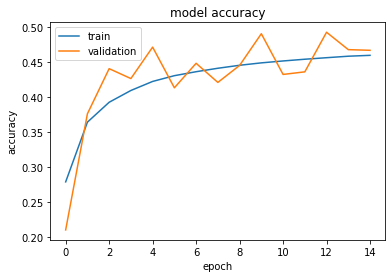

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

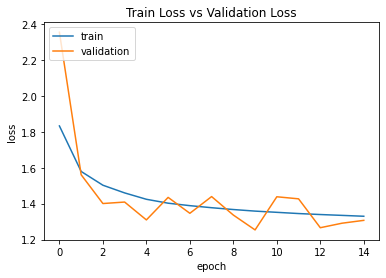

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train Loss vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Testing

In [ ]:
pred_test = cnn.predict(xtest)
y_pred = one_hot_encoder.inverse_transform(pred_test)
ytest_decoded = one_hot_encoder.inverse_transform(ytest)


<Figure size 720x720 with 0 Axes>

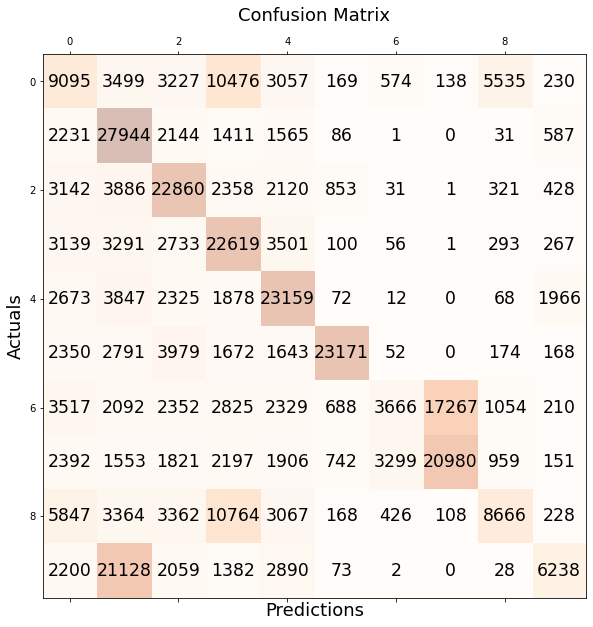

In [ ]:
con_mat = confusion_matrix(ytest_decoded, y_pred)
plt.figure(figsize = (10, 10))
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(con_mat, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(ytest_decoded, y_pred))

              precision    recall  f1-score   support

        8PSK       0.25      0.25      0.25     36000
      AM-DSB       0.38      0.78      0.51     36000
        BPSK       0.49      0.64      0.55     36000
       CPFSK       0.39      0.63      0.48     36000
        GFSK       0.51      0.64      0.57     36000
        PAM4       0.89      0.64      0.75     36000
       QAM16       0.45      0.10      0.17     36000
       QAM64       0.55      0.58      0.56     36000
        QPSK       0.51      0.24      0.33     36000
        WBFM       0.60      0.17      0.27     36000

    accuracy                           0.47    360000
   macro avg       0.50      0.47      0.44    360000
weighted avg       0.50      0.47      0.44    360000

